# JMH Benchmark Parser & Plotting Toolkit

This notebook provides:
1. A parser to extract datasets from JMH-style table output into typed arrays grouped by benchmark name.
2. Plotting helpers to compare **2, 3, 4, or 5** datasets on one chart.
3. A regression plotter that overlays a polynomial fit of configurable degree.

**Conventions**
- Parsed structure per benchmark: `List[Tuple[int, Tuple[float, float]]]` → `(size, (avg, error))`.
- `size` is taken from the filename part like `... 2_456chars.json ...` → `456`.
- Plot functions accept optional `output_folder` and `fmt` (`"svg"` or `"eps"`). If provided, figures are saved there.


In [12]:

# Imports (matplotlib only; seaborn intentionally not used)
from __future__ import annotations
import re
from typing import Dict, List, Tuple, Sequence, Iterable, Optional
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def _ensure_save(fig, filename: Optional[str|Path], fmt: str = "svg", output_folder: Optional[str|Path] = None):
    """Save `fig` if `output_folder` is provided. Returns output path or None."""
    if output_folder is None:
        return None
    fmt = (fmt or "svg").lower()
    if fmt not in {"svg", "eps", "pdf", "png"}:
        raise ValueError(f"Unsupported format: {fmt!r}. Use 'svg', 'eps', 'pdf', or 'png'.")
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    filename = Path(filename) if filename is not None else Path("figure")
    outpath = output_folder / (filename.stem + f".{fmt}")
    fig.savefig(outpath, format=fmt, bbox_inches="tight", dpi=300)
    return outpath


In [13]:

def parse_jmh_table(raw_text: str) -> Dict[str, List[Tuple[int, Tuple[float, float]]]]:
    """Parse JMH-like '[info] Benchmark ...' table lines into datasets.

    Returns a dict mapping benchmark name → list of (size, (avg, error)).
    The list is sorted by size. Lines that don't match the expected table pattern are ignored.

    Expected columns pattern (loose, handles variable spacing):
      [info] <BenchmarkName> <file> <mode> <cnt> <score> ± <error> <units>

    Size extraction rule:
      Take the integer *immediately before* the 'chars' token in the filename.
      E.g., '102_23677chars.json' → 23677 ; '2_456chars.json' → 456.
    """
    datasets: Dict[str, List[Tuple[int, Tuple[float, float]]]] = {}

    # Regex for the table line
    line_re = re.compile(
        r"^\[info\]\s+"                               # prefix
        r"(?P<bench>\S+)\s+"                           # benchmark name
        r"(?P<file>\S+)\s+"                            # filename token
        r"(?P<mode>\S+)\s+"                            # mode (e.g., avgt)
        r"(?P<cnt>\d+)\s+"                             # count
        r"(?P<score>\d+(?:\.\d+)?)\s+"               # score (avg)
        r"±\s+"
        r"(?P<error>\d+(?:\.\d+)?)\s+"               # error
        r"(?P<units>\S+)\s*$"                          # units
    )

    # Extract the size found right before 'chars' inside the file token
    size_re = re.compile(r"_(?P<size>\d+)chars\b", re.IGNORECASE)

    for line in raw_text.splitlines():
        m = line_re.match(line)
        if not m:
            continue

        bench = m.group("bench")
        filetok = m.group("file")
        score = float(m.group("score"))
        error = float(m.group("error"))

        sm = size_re.search(filetok)
        if not sm:
            # If pattern fails, try to fallback to the last integer run in the token
            # (keeps the parser resilient for edge cases).
            m2 = re.search(r"(\d+)(?=\D*$)", filetok)
            if not m2:
                continue
            size = int(m2.group(1))
        else:
            size = int(sm.group("size"))

        datasets.setdefault(bench, []).append((size, (score, error)))

    # Sort each dataset by size
    for k in list(datasets.keys()):
        datasets[k].sort(key=lambda t: t[0])

    return datasets


In [14]:

from matplotlib import colors

def _clean_filename(s: str) -> str:
    filename_clean = s.replace("\n", "_").replace(" ", "_").replace("/", "_").replace(":", "_").replace(",", "_").replace(".", "_").replace("(", "_").replace(")", "_")
    changed = True
    while changed:
        new_clean = filename_clean.replace("__", "_")
        changed = (new_clean != filename_clean)
        filename_clean = new_clean
    return filename_clean

def _prep_xy(series: List[Tuple[int, Tuple[float, float]]]):
    xs = [s for s, _ in series]
    ys = [v[0] for _, v in series]
    yerr = [v[1] for _, v in series]
    return np.array(xs), np.array(ys), np.array(yerr)

# A list of easily distinguishable colors for colorblind-safe plots
_COLOR_CYCLE = [
    "#007bff",  # blue
    "#ff7f00",  # orange
    "#000000",  # black
    "#ff47a6",  # pink
    "#bdbd1d",  # yellow
    "#006354",  # teal
]

def _plot_many(datasets: Sequence[Tuple[str, List[Tuple[int, Tuple[float, float]]]]], 
               pretty_data_labels: Optional[Dict[str, str]] = None,
               title: Optional[str] = None,
               show_title: bool = False,
               output_folder: Optional[str|Path] = None,
               fmt: str = "svg",
               time_unit: str = "µs",
               convert_data_from_micro_sec: bool = False,
               filename: Optional[str|Path] = None):
    n = len(datasets)
    if n < 2 or n > 6:
        raise ValueError("_plot_many expects between 2 and 6 datasets.")
    
    factor = 1.0
    if convert_data_from_micro_sec:
        # We convert from µs to the desired time unit
        if time_unit == "ms":
            factor = 1e-3
        elif time_unit == "s":
            factor = 1e-6
        elif time_unit == "ns":
            factor = 1e3    
        elif time_unit == "µs":
            factor = 1.0
        else:
            raise ValueError(f"Unsupported time unit for conversion: {time_unit!r}. Use 'ns', 'µs', 'ms', or 's'.")


    fig, ax = plt.subplots(figsize=(7, 5))
    index = 0
    for label, series in datasets:
        xs, ys, yerr = _prep_xy(series)
        ys = ys * factor
        yerr = yerr * factor
        if pretty_data_labels and label in pretty_data_labels:
            label = pretty_data_labels[label]
        ax.errorbar(xs, ys, yerr=yerr, marker='o', linestyle='', label=label, 
                    color=_COLOR_CYCLE[index % len(_COLOR_CYCLE)],
                    capsize=3)
        index += 1
    ax.set_xlabel("Input size (chars)")
    ax.set_ylabel(f"Time ({time_unit})")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    if title and show_title:
        ax.set_title(title)
    ax.legend()

    filename_clean = _clean_filename((filename or (title or f"compare_{n}_datasets")))
    
    saved = _ensure_save(fig, filename_clean, fmt, output_folder)
    plt.show()
    return saved

def plot2(d1: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          d2: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          pretty_data_labels: Optional[Dict[str, str]] = None,
          title: Optional[str] = None,
          show_title: bool = False,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None):
    """Plot 2 datasets on the same axes."""
    return _plot_many([d1, d2], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename)

def plot3(d1, d2, d3, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None):
    """Plot 3 datasets on the same axes."""
    return _plot_many([d1, d2, d3], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename)

def plot4(d1, d2, d3, d4, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None):
    """Plot 4 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename)

def plot5(d1, d2, d3, d4, d5, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None):
    """Plot 5 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4, d5], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename)

def plot6(d1, d2, d3, d4, d5, d6, title: Optional[str] = None,
          show_title: bool = False,
          pretty_data_labels: Optional[Dict[str, str]] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          time_unit: str = "µs",
          convert_data_from_micro_sec: bool = False,
          filename: Optional[str|Path] = None):
    """Plot 6 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4, d5, d6], pretty_data_labels=pretty_data_labels, title=title, show_title=show_title, output_folder=output_folder, time_unit=time_unit, convert_data_from_micro_sec=convert_data_from_micro_sec, fmt=fmt, filename=filename)


In [15]:

def _print_poly(poly: np.poly1d):
    equation = ""
    degree = len(poly.coeffs) - 1
    for i, coeff in enumerate(poly.coeffs):
        power = degree - i
        coeff_abs = abs(coeff)
        if coeff < 0:
            equation += " - "
        else:
            if i > 0:
                equation += " + "
        if power == 0:
            equation += f"{coeff_abs:.4g}"
        elif power == 1:
            equation += f"{coeff_abs:.4g}*x"
        else:
            equation += f"{coeff_abs:.4g}*x^{power}"
    print(f"Polynomial function f(x) = {equation}")

def plot_with_regression(dataset: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
                         degree: int = 1,
                         title: Optional[str] = None,
                         show_title: bool = False,
                         color: Optional[str] = None,
                         pretty_data_labels: Optional[Dict[str, str]] = None,
                         output_folder: Optional[str|Path] = None,
                         fmt: str = "svg",
                         time_unit: str = "µs",
                         filename: Optional[str|Path] = None):
    """Plot a dataset with error bars and overlay a polynomial regression of given degree.

    Parameters
    ----------
    dataset : (name, series) where series is List[(size, (avg, error))].
    degree : polynomial degree (>= 0).
    title : optional str for the plot title.
    output_folder : optional path to save the plot.
    fmt : 'svg' or 'eps' (default: 'svg').
    filename : optional filename stem for saving.
    """
    if degree < 0:
        raise ValueError("degree must be >= 0")

    label, series = dataset
    xs, ys, yerr = _prep_xy(series)

    # Fit polynomial
    coeffs = np.polyfit(xs, ys, deg=degree)
    poly = np.poly1d(coeffs)

    # Smooth line over the observed range
    xfit = np.linspace(xs.min(), xs.max(), 500)
    yfit = poly(xfit)


    fig, ax = plt.subplots(figsize=(7, 5))
    if pretty_data_labels and label in pretty_data_labels:
            label = pretty_data_labels[label]
    ax.errorbar(xs, ys, yerr=yerr, marker='o', color=color, linestyle='--', label=f"{label}")
    ax.plot(xfit, yfit, label=f"Poly deg {degree}")
    ax.set_xlabel("Input size (chars)")
    ax.set_ylabel(f"Time ({time_unit})")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    ax.legend()
    if title and show_title:
        ax.set_title(title)

    filename_clean = _clean_filename((filename or (title or f"regression_deg{degree}_{label}")))

    saved = _ensure_save(fig, filename_clean, fmt, output_folder)
    plt.show()
    _print_poly(poly)
    return saved



### Usage
```python
raw = """<paste your JMH output here>"""
data = parse_jmh_table(raw)

# Example: build tuples for plotting
bench1 = "JsonLexerBenchmark.lex_ZipperMem"
bench2 = "JsonLexerBenchmark.separability_pred"
d1 = (bench1, data[bench1])
d2 = (bench2, data[bench2])

# Compare two datasets
plot2(d1, d2, title="Lex vs Separability", output_folder="plots", fmt="svg")

# Regression for one dataset
plot_with_regression(d2, degree=1, title="Separability: Linear Fit", output_folder="plots", fmt="svg")
```


# JSON Lexer Benchmark Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


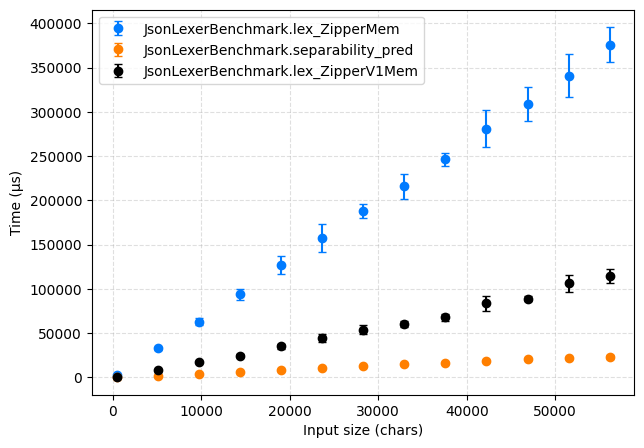

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


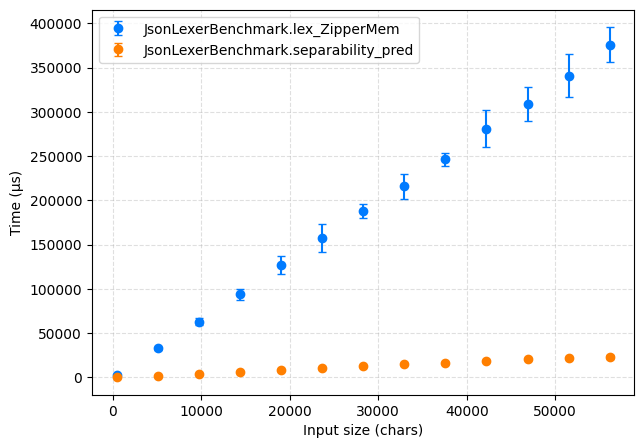

In [16]:
latest_folder = Path("./latest")
json_lexer_file = None
for entry in os.listdir(latest_folder):
    if 'json_lexer' in entry.lower():
        json_lexer_file = latest_folder / entry
        break

bench1 = "JsonLexerBenchmark.lex_ZipperMem"
bench2 = "JsonLexerBenchmark.separability_pred"
bench3 = "JsonLexerBenchmark.lex_ZipperV1Mem"
    
assert json_lexer_file is not None, "Could not find JSON lexer benchmark file in 'latest' folder."
with open(json_lexer_file, "r") as f:
    raw2 = f.read()
data2 = parse_jmh_table(raw2)
if bench1 in data2 and bench2 in data2 and bench3 in data2:
    d1_new = (bench1, data2[bench1])
    d2_new = (bench2, data2[bench2])
    d3_new = (bench3, data2[bench3])
    plot3(d1_new, d2_new, d3_new, title="JSON: Lex vs Separability vs LexV1 (Latest)", output_folder="plots", fmt="eps")
    plot2(d1_new, d2_new, title="JSON: Lex vs Separability (Latest)", output_folder="plots", fmt="eps")
else:
    print(f"Benchmarks {bench1} or {bench2} not found in the latest data.")

# JSON Manipulation Benchmark Results

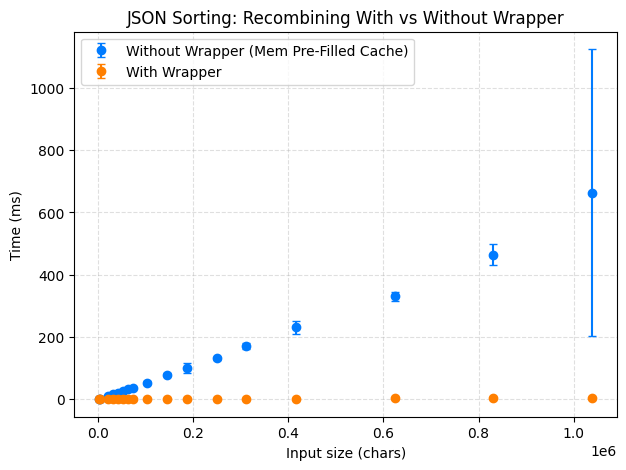

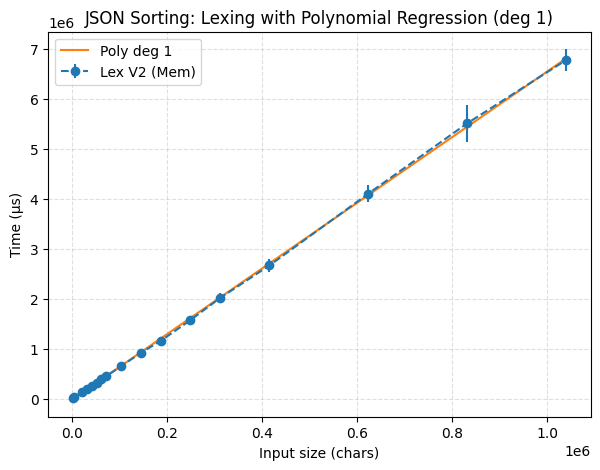

Polynomial function f(x) = 6.578*x - 2.699e+04


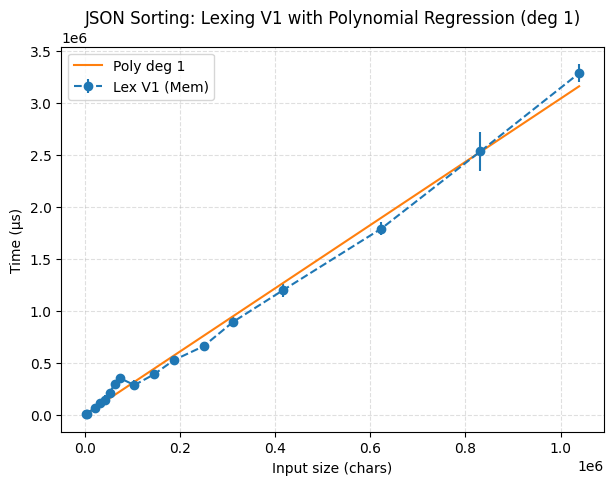

Polynomial function f(x) = 3.044*x - 253.7


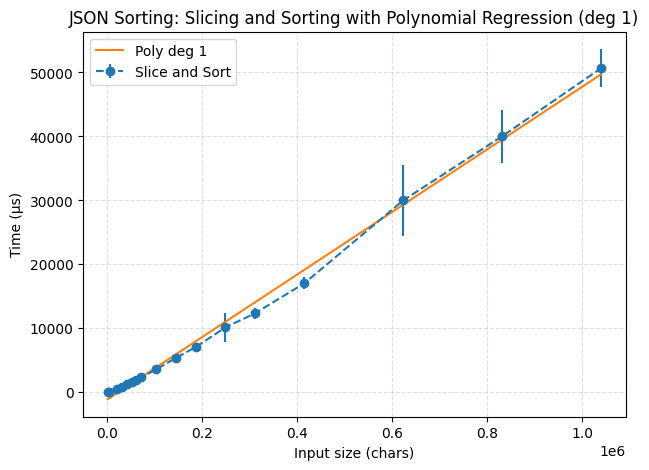

Polynomial function f(x) = 0.04898*x - 1188


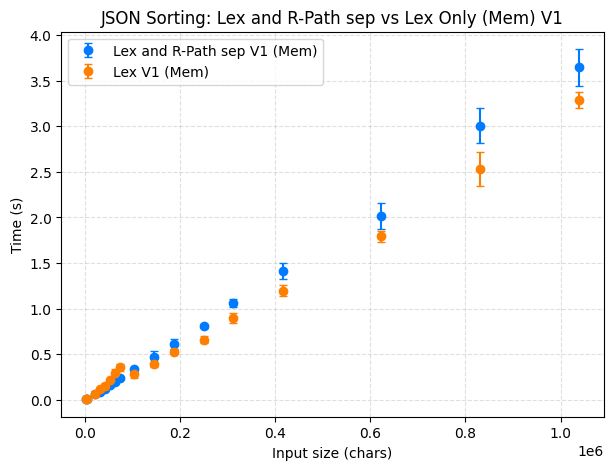

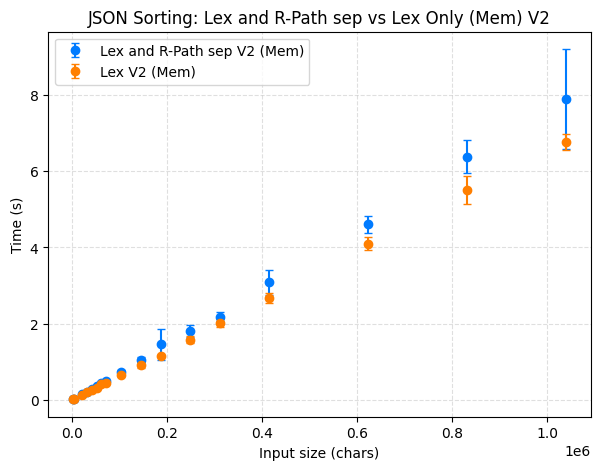

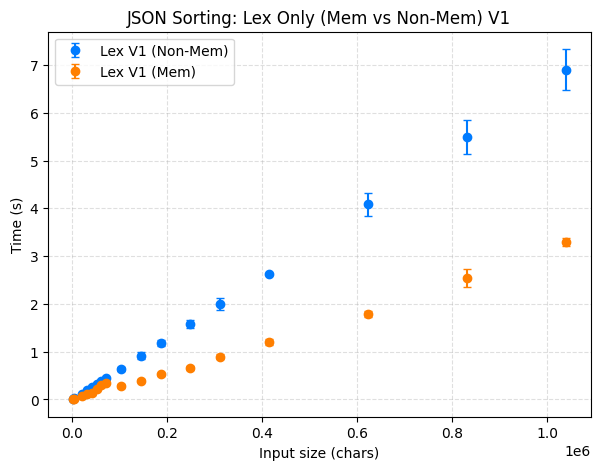

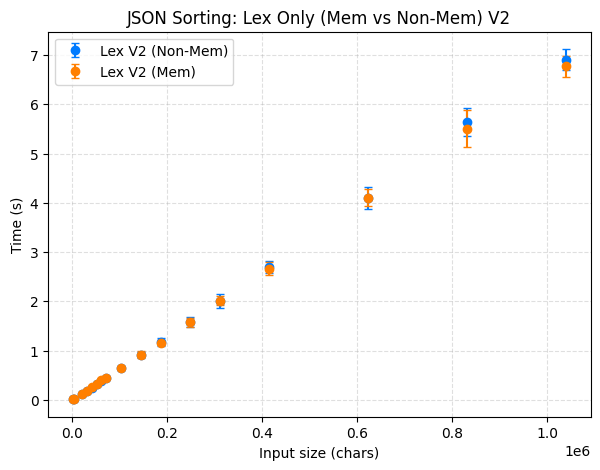

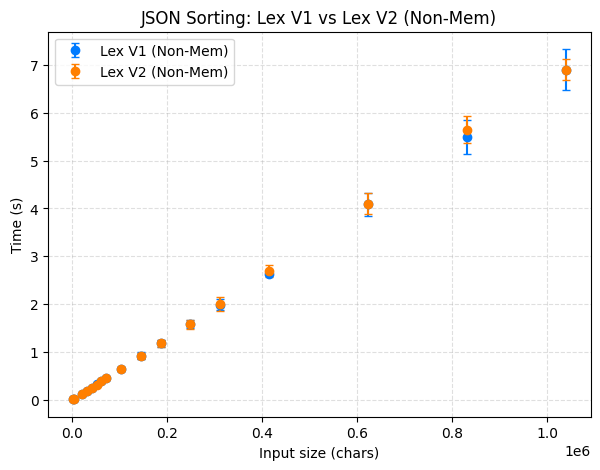

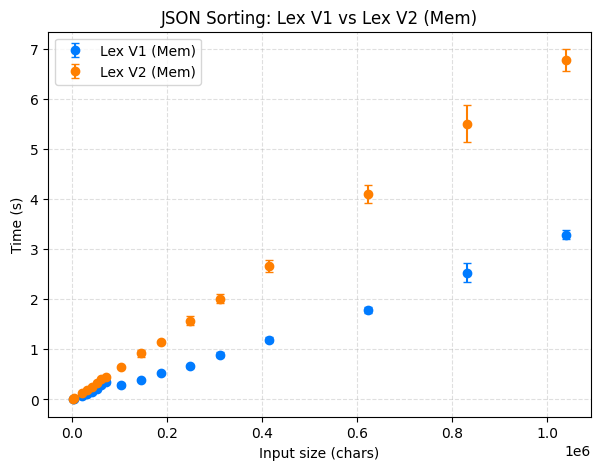

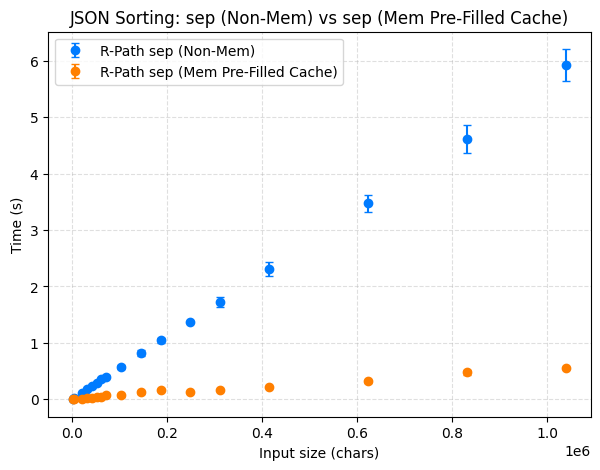

PosixPath('plots/JSON_Sorting_sep_Non-Mem_vs_sep_Mem_Pre-Filled_Cache_.pdf')

In [22]:
latest_folder = Path("./latest")
json_manipulation_file = None
for entry in os.listdir(latest_folder):
    if 'json_manipulation' in entry.lower():
        json_manipulation_file = latest_folder / entry
        break

# If found, parse and plot
assert json_manipulation_file is not None, "No json_manipulation file found in latest folder."
with open(json_manipulation_file, "r") as f:
  raw3 = f.read()
  data3 = parse_jmh_table(raw3)

benchRecombineWithoutWrapper = "JsonManipulationBenchmark.checkPredicateAndRecombineWithoutWrapper"
benchLex = "JsonManipulationBenchmark.lex"
benchLexV1 = "JsonManipulationBenchmark.lexV1"
benchLexV1NonMem = "JsonManipulationBenchmark.lexV1NonMem"
benchLexV2NonMem = "JsonManipulationBenchmark.lexV2NonMem"
benchLexAndCheckPrintableV1 = "JsonManipulationBenchmark.lexAndCheckPrintableV1"
benchLexAndCheckPrintableV2 = "JsonManipulationBenchmark.lexAndCheckPrintableV2"
benchRecombineSlices = "JsonManipulationBenchmark.recombineSlices"
benchSliceAndSort = "JsonManipulationBenchmark.sliceAndSort"
benchCheckPrintableNonMem = "JsonManipulationBenchmark.checkPrintableNonMem"
benchCheckPrintable = "JsonManipulationBenchmark.checkPrintableMemPreFilledCache"

pretty_labels = {
      benchRecombineWithoutWrapper: "Without Wrapper (Mem Pre-Filled Cache)",
      benchLex: "Lex V2 (Mem)",
      benchLexV1: "Lex V1 (Mem)",
      benchLexV1NonMem: "Lex V1 (Non-Mem)",
      benchLexV2NonMem: "Lex V2 (Non-Mem)",
      benchLexAndCheckPrintableV1: "Lex and R-Path sep V1 (Mem)",
      benchLexAndCheckPrintableV2: "Lex and R-Path sep V2 (Mem)",
      benchRecombineSlices: "With Wrapper",
      benchSliceAndSort: "Slice and Sort",
      benchCheckPrintableNonMem: "R-Path sep (Non-Mem)",
      benchCheckPrintable: "R-Path sep (Mem Pre-Filled Cache)"
}

plot2((benchRecombineWithoutWrapper, data3[benchRecombineWithoutWrapper]),
      (benchRecombineSlices, data3[benchRecombineSlices]),
      title="JSON Sorting: Recombining With vs Without Wrapper",
      show_title=True,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="ms",
      convert_data_from_micro_sec=True,
      fmt="pdf")

plot_with_regression((benchLex, data3[benchLex]),
                     degree=1,
                     title="JSON Sorting: Lexing with Polynomial Regression (deg 1)",
                     show_title=True,
                     output_folder="plots",
                     pretty_data_labels=pretty_labels,
                     fmt="pdf")

plot_with_regression((benchLexV1, data3[benchLexV1]),
                     degree=1,
                     title="JSON Sorting: Lexing V1 with Polynomial Regression (deg 1)",
                     show_title=True,
                     output_folder="plots",
                     pretty_data_labels=pretty_labels,
                     fmt="pdf")

plot_with_regression((benchSliceAndSort, data3[benchSliceAndSort]),
                     degree=1,
                     title="JSON Sorting: Slicing and Sorting with Polynomial Regression (deg 1)",
                     show_title=True,
                     output_folder="plots",
                     pretty_data_labels=pretty_labels,
                     fmt="pdf")

plot2((benchLexAndCheckPrintableV1, data3[benchLexAndCheckPrintableV1]),
      (benchLexV1, data3[benchLexV1]),
      title="JSON Sorting: Lex and R-Path sep vs Lex Only (Mem) V1",
      show_title=True,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf")

plot2((benchLexAndCheckPrintableV2, data3[benchLexAndCheckPrintableV2]),
      (benchLex, data3[benchLex]),
      title="JSON Sorting: Lex and R-Path sep vs Lex Only (Mem) V2",
      show_title=True,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf")

plot2(
      (benchLexV1NonMem, data3[benchLexV1NonMem]),
      (benchLexV1, data3[benchLexV1]),
      title="JSON Sorting: Lex Only (Mem vs Non-Mem) V1",
      show_title=True,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf")

plot2(
      (benchLexV2NonMem, data3[benchLexV2NonMem]),
      (benchLex, data3[benchLex]),
      title="JSON Sorting: Lex Only (Mem vs Non-Mem) V2",
      show_title=True,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf")

plot2(
      (benchLexV1NonMem, data3[benchLexV1NonMem]),
      (benchLexV2NonMem, data3[benchLexV2NonMem]),
      title="JSON Sorting: Lex V1 vs Lex V2 (Non-Mem)",
      show_title=True,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf")

plot2(
      (benchLexV1, data3[benchLexV1]),
      (benchLex, data3[benchLex]),
      title="JSON Sorting: Lex V1 vs Lex V2 (Mem)",
      show_title=True,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf"
)

plot2(
      (benchCheckPrintableNonMem, data3[benchCheckPrintableNonMem]),
      (benchCheckPrintable, data3[benchCheckPrintable]),
      title="JSON Sorting: sep (Non-Mem) vs sep (Mem Pre-Filled Cache)",
      show_title=True,
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      time_unit="s",
      convert_data_from_micro_sec=True,
      fmt="pdf")




# Basic Regex Benchmark Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


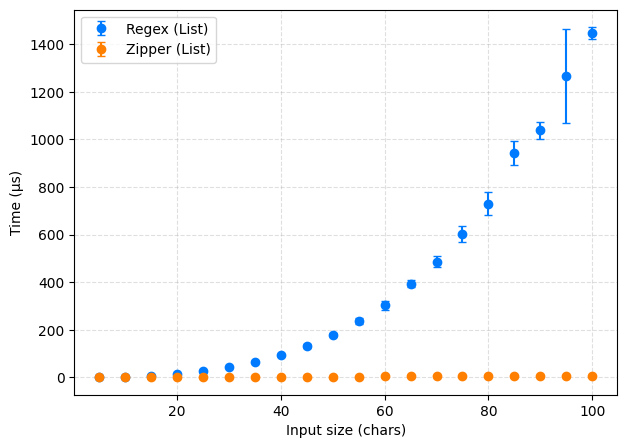

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


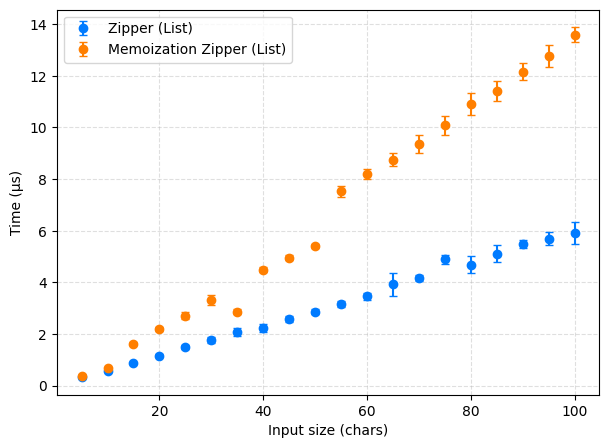

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


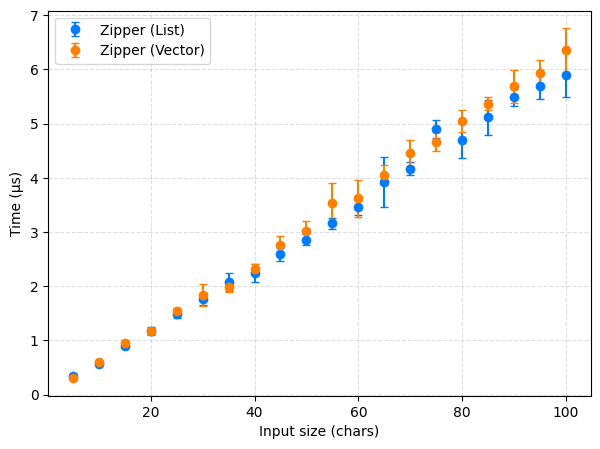

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


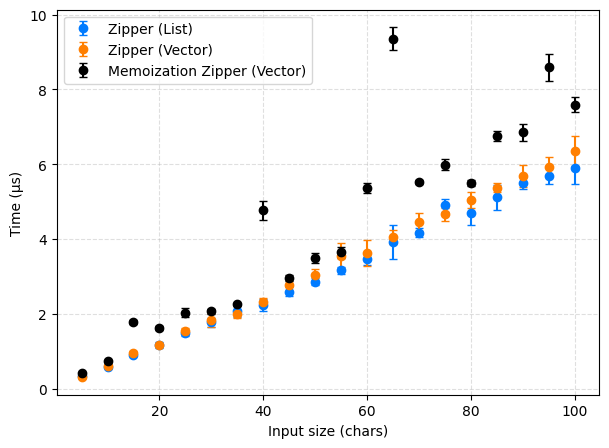

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


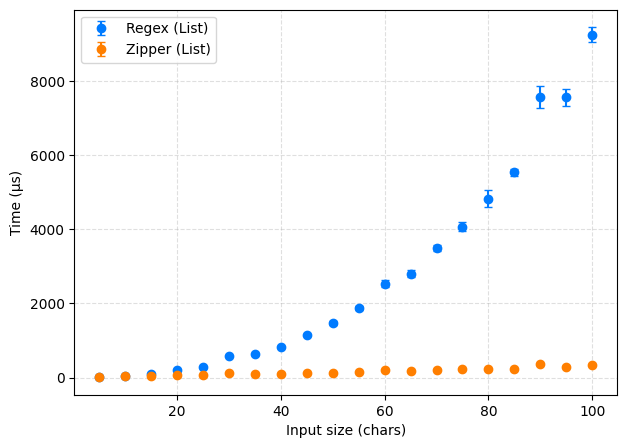

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


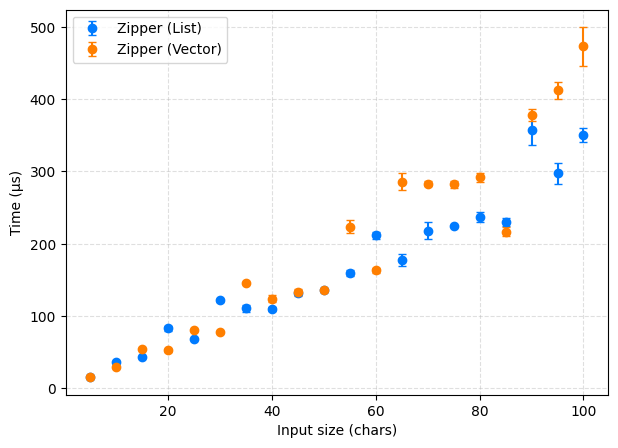

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


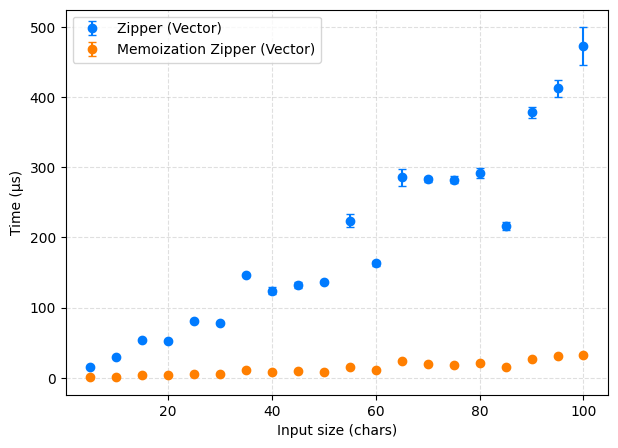

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


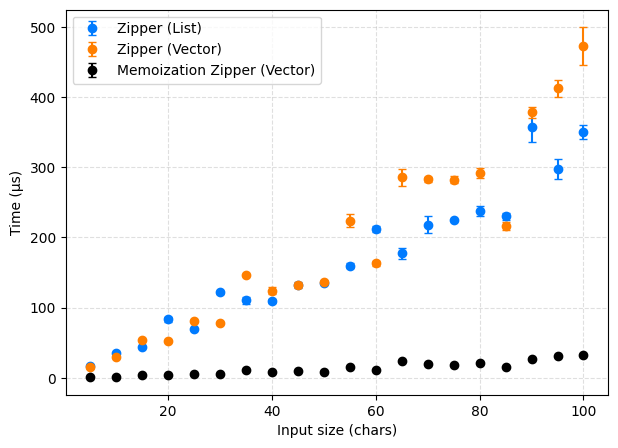

PosixPath('plots/Regex_Email_Accepting_-_Zipper_List_vs_Vector_and_Memoization_Zipper_Vector_.eps')

In [18]:
latest_folder = Path("./latest")
regex_benchmark_file = None
for entry in os.listdir(latest_folder):
    if entry.lower().startswith('regex_benchmark'):
        regex_benchmark_file = latest_folder / entry
        break

assert regex_benchmark_file is not None, "Could not find regex benchmark file in 'latest' folder."
with open(regex_benchmark_file, "r") as f:
    raw4 = f.read()
data4 = parse_jmh_table(raw4)

abStarAccepting_Regex_list = "RegexBenchmark.abStarAccepting_Regex_list"
abStarAccepting_ZipperMem_list = "RegexBenchmark.abStarAccepting_ZipperMem_list"
abStarAccepting_ZipperMem_vector = "RegexBenchmark.abStarAccepting_ZipperMem_vector"
abStarAccepting_Zipper_list = "RegexBenchmark.abStarAccepting_Zipper_list"
abStarAccepting_Zipper_vector = "RegexBenchmark.abStarAccepting_Zipper_vector"
emailAccepting_RegexMem_list = "RegexBenchmark.emailAccepting_RegexMem_list"
emailAccepting_Regex_list = "RegexBenchmark.emailAccepting_Regex_list"
emailAccepting_ZipperMem_vector = "RegexBenchmark.emailAccepting_ZipperMem_vector"
emailAccepting_Zipper_list = "RegexBenchmark.emailAccepting_Zipper_list"
emailAccepting_Zipper_vector = "RegexBenchmark.emailAccepting_Zipper_vector"

pretty_labels = {
      abStarAccepting_Regex_list: "Regex (List)",
      abStarAccepting_Zipper_list: "Zipper (List)",
      abStarAccepting_ZipperMem_list: "Memoization Zipper (List)",
      abStarAccepting_Zipper_vector: "Zipper (Vector)",
      abStarAccepting_ZipperMem_vector: "Memoization Zipper (Vector)",
      emailAccepting_Regex_list: "Regex (List)",
      emailAccepting_RegexMem_list: "Memoization Regex (List)",
      emailAccepting_Zipper_list: "Zipper (List)",
      emailAccepting_Zipper_vector: "Zipper (Vector)",
      emailAccepting_ZipperMem_vector: "Memoization Zipper (Vector)",
}

plot2((abStarAccepting_Regex_list, data4[abStarAccepting_Regex_list]),
      (abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      title="Regex: ab* Accepting - Regex vs Zipper (List)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_ZipperMem_list, data4[abStarAccepting_ZipperMem_list]),
      title="Regex: ab* Accepting - Zipper vs Memoization Zipper (List)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_Zipper_vector, data4[abStarAccepting_Zipper_vector]),
      title="Regex: ab* Accepting - Zipper (List vs Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot3((abStarAccepting_Zipper_list, data4[abStarAccepting_Zipper_list]),
      (abStarAccepting_Zipper_vector, data4[abStarAccepting_Zipper_vector]),
      (abStarAccepting_ZipperMem_vector, data4[abStarAccepting_ZipperMem_vector]),
      title="Regex: ab* Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((emailAccepting_Regex_list, data4[emailAccepting_Regex_list]),
      (emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      title="Regex: Email Accepting - Regex vs Zipper (List)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      (emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      title="Regex: Email Accepting - Zipper (List vs Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot2((emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      (emailAccepting_ZipperMem_vector, data4[emailAccepting_ZipperMem_vector]),
      title="Regex: Email Accepting - Zipper vs Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")

plot3((emailAccepting_Zipper_list, data4[emailAccepting_Zipper_list]),
      (emailAccepting_Zipper_vector, data4[emailAccepting_Zipper_vector]),
      (emailAccepting_ZipperMem_vector, data4[emailAccepting_ZipperMem_vector]),
      title="Regex: Email Accepting - Zipper (List vs Vector) and Memoization Zipper (Vector)",
      pretty_data_labels=pretty_labels,
      output_folder="plots",
      fmt="eps")


# Lexer Comments Regex Benchmarks

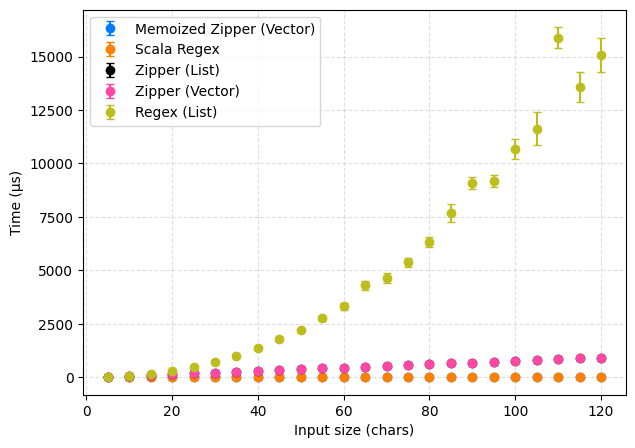

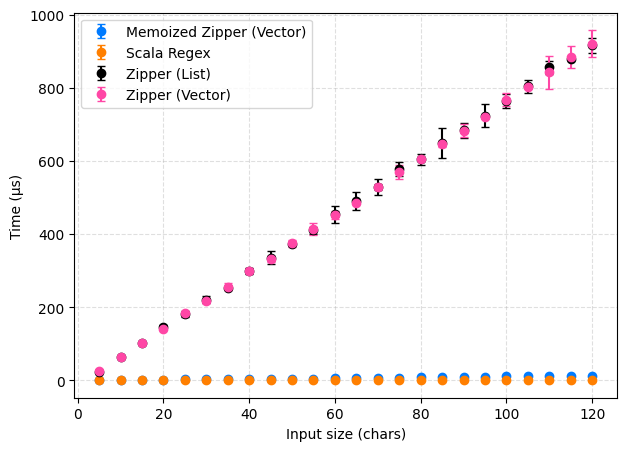

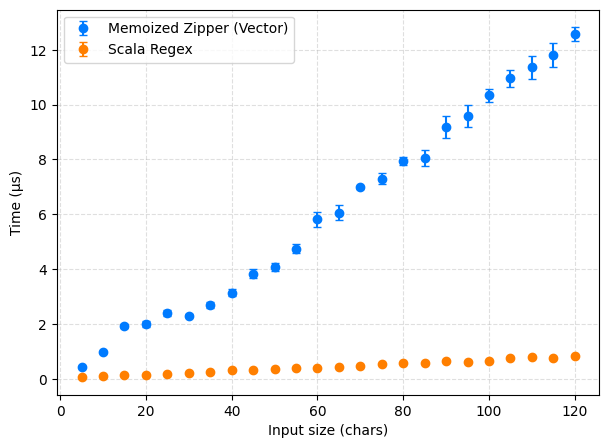

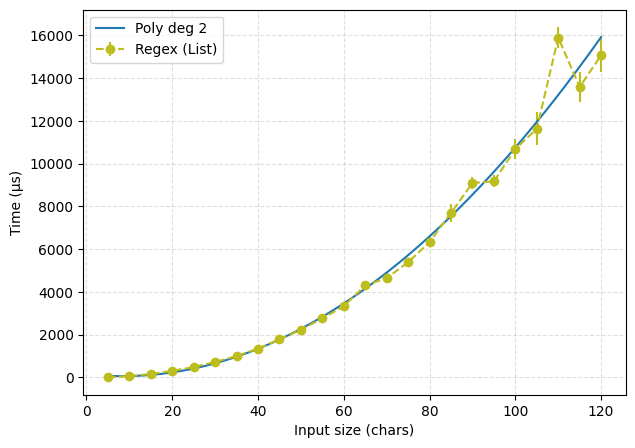

Polynomial function f(x) = 1.269*x^2 - 20.89*x + 144.6


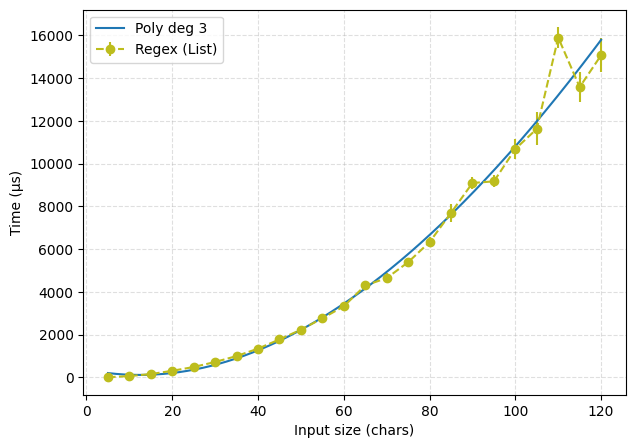

Polynomial function f(x) =  - 0.001983*x^3 + 1.641*x^2 - 39.86*x + 362.1


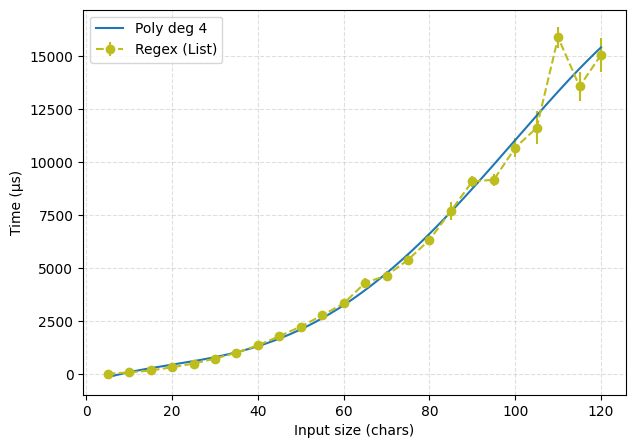

Polynomial function f(x) =  - 0.0001922*x^4 + 0.04607*x^3 - 2.275*x^2 + 74.27*x - 481.2


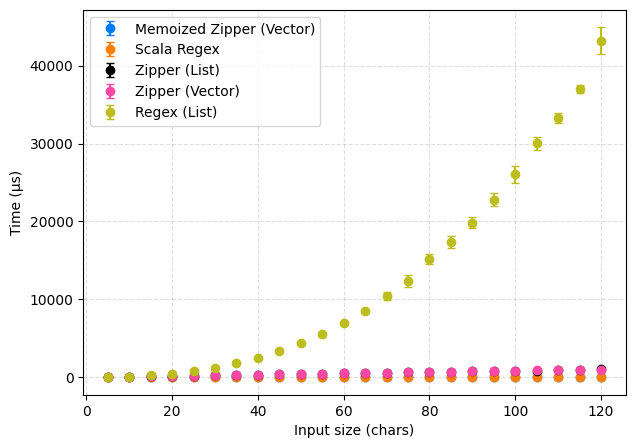

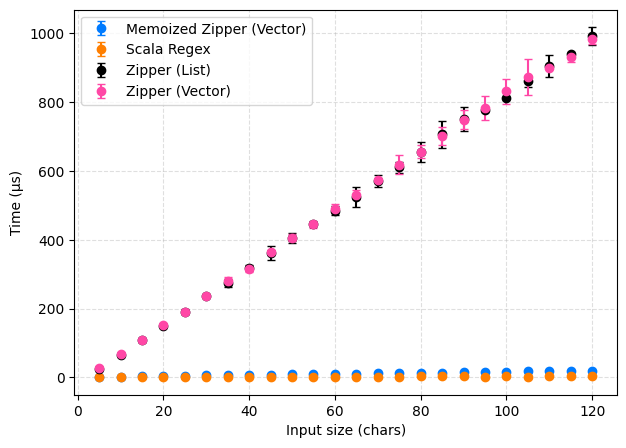

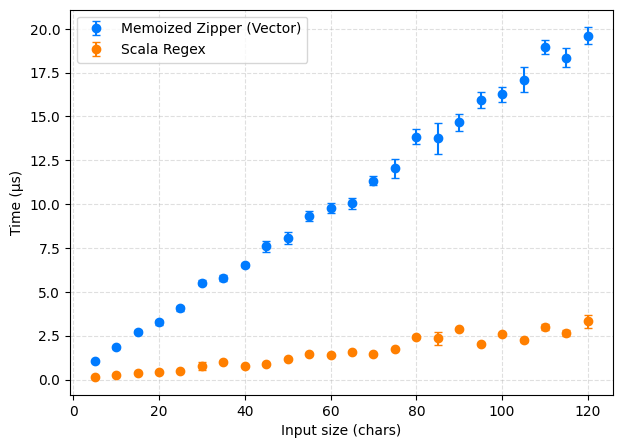

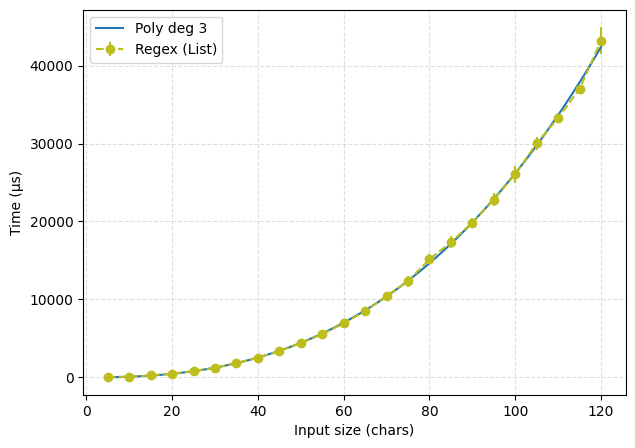

Polynomial function f(x) = 0.01576*x^3 + 1.105*x^2 - 6.413*x + 13.02


PosixPath('plots/Multi-line_Comments_Matching_Regex_List_with_Polynomial_Regression_deg_3_.pdf')

In [19]:
latest_folder = Path("./latest")
regex_benchmark_file = None
for entry in os.listdir(latest_folder):
    if 'lexerregex_benchmark' in entry.lower():
        lexer_regex_benchmark_file = latest_folder / entry
        break

assert lexer_regex_benchmark_file is not None, "Could not find regex benchmark file in 'latest' folder."
with open(lexer_regex_benchmark_file, "r") as f:
    raw5 = f.read()
data5 = parse_jmh_table(raw5)

pretty_labels = {
        "LexerRegexBenchmark.commentAccepting_Regex_list": "Regex (List)",
        "LexerRegexBenchmark.commentAccepting_Regex_multiline_list": "Regex (List)",
        "LexerRegexBenchmark.commentAccepting_ZipperNMem_vector" : "Memoized Zipper (Vector)",
        "LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem": "Memoized Zipper (Vector)",
        "LexerRegexBenchmark.commentAccepting_Zipper_list": "Zipper (List)",
        "LexerRegexBenchmark.commentAccepting_Zipper_multiline_list": "Zipper (List)",
        "LexerRegexBenchmark.commentAccepting_Zipper_vector": "Zipper (Vector)",
        "LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector": "Zipper (Vector)",
        "LexerRegexBenchmark.commentAccepting_scalaRegex": "Scala Regex",
        "LexerRegexBenchmark.commentAccepting_scalaRegex_multiline": "Scala Regex",
}


# Single line comments


plot5(
    ("LexerRegexBenchmark.commentAccepting_ZipperNMem_vector", data5["LexerRegexBenchmark.commentAccepting_ZipperNMem_vector"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex", data5["LexerRegexBenchmark.commentAccepting_scalaRegex"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_list", data5["LexerRegexBenchmark.commentAccepting_Zipper_list"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_vector", data5["LexerRegexBenchmark.commentAccepting_Zipper_vector"]),
    ("LexerRegexBenchmark.commentAccepting_Regex_list", data5["LexerRegexBenchmark.commentAccepting_Regex_list"]),
    title="Single Line Comments Matching\nRegex vs Zipper vs Scala Regex (List and Vector, with and w/ Memo)",
    pretty_data_labels=pretty_labels,
    output_folder="plots",
    fmt="pdf")

plot4(
    ("LexerRegexBenchmark.commentAccepting_ZipperNMem_vector", data5["LexerRegexBenchmark.commentAccepting_ZipperNMem_vector"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex", data5["LexerRegexBenchmark.commentAccepting_scalaRegex"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_list", data5["LexerRegexBenchmark.commentAccepting_Zipper_list"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_vector", data5["LexerRegexBenchmark.commentAccepting_Zipper_vector"]),
    title="Single Line Comments\nZipper vs Scala Regex (List and Vector, with and w/ Memoization)",
    pretty_data_labels=pretty_labels,
    output_folder="plots",
    fmt="pdf")

plot2(("LexerRegexBenchmark.commentAccepting_ZipperNMem_vector", data5["LexerRegexBenchmark.commentAccepting_ZipperNMem_vector"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex", data5["LexerRegexBenchmark.commentAccepting_scalaRegex"]),
    title="Single Line Comments\nZipper vs Scala Regex (Vector, with Memoization)",
    pretty_data_labels=pretty_labels,
    output_folder="plots",
    fmt="pdf")

deg = 2
plot_with_regression(("LexerRegexBenchmark.commentAccepting_Regex_list", data5["LexerRegexBenchmark.commentAccepting_Regex_list"]),
                     degree=deg,
                     title=f"Single Line Comments Matching\nRegex (List) with Polynomial Regression (deg {deg})",
                     pretty_data_labels=pretty_labels,
                     color=_COLOR_CYCLE[4],
                     output_folder="plots",
                     fmt="pdf")

deg = 3
plot_with_regression(("LexerRegexBenchmark.commentAccepting_Regex_list", data5["LexerRegexBenchmark.commentAccepting_Regex_list"]),
                     degree=deg,
                     title=f"Single Line Comments Matching\nRegex (List) with Polynomial Regression (deg {deg})",
                     pretty_data_labels=pretty_labels,
                     color=_COLOR_CYCLE[4],
                     output_folder="plots",
                     fmt="pdf")

deg = 4
plot_with_regression(("LexerRegexBenchmark.commentAccepting_Regex_list", data5["LexerRegexBenchmark.commentAccepting_Regex_list"]),
                     degree=deg,
                     title=f"Single Line Comments Matching\nRegex (List) with Polynomial Regression (deg {deg})",
                     pretty_data_labels=pretty_labels,
                     color=_COLOR_CYCLE[4],
                     output_folder="plots",
                     fmt="pdf")



# Mutli-line comments

plot5(
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex_multiline", data5["LexerRegexBenchmark.commentAccepting_scalaRegex_multiline"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_list", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_list"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector"]),
    ("LexerRegexBenchmark.commentAccepting_Regex_multiline_list", data5["LexerRegexBenchmark.commentAccepting_Regex_multiline_list"]),
    title="Multi-line Comments Matching\nRegex vs Zipper vs Scala Regex (List and Vector, with and w/ Memo)",
    pretty_data_labels=pretty_labels,
    output_folder="plots",
    fmt="pdf")

plot4(
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex_multiline", data5["LexerRegexBenchmark.commentAccepting_scalaRegex_multiline"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_list", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_list"]),
    ("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector"]),
    title="Multi-line Comments\nZipper vs Scala Regex (List and Vector, with and w/ Memoization)",
    pretty_data_labels=pretty_labels,
    output_folder="plots",
    fmt="pdf")

plot2(("LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem", data5["LexerRegexBenchmark.commentAccepting_Zipper_multiline_vector_mem"]),
    ("LexerRegexBenchmark.commentAccepting_scalaRegex_multiline", data5["LexerRegexBenchmark.commentAccepting_scalaRegex_multiline"]),
    title="Multi-line Comments\nZipper vs Scala Regex (Vector, with Memoization)",
    pretty_data_labels=pretty_labels,
    output_folder="plots",
    fmt="pdf")

plot_with_regression(("LexerRegexBenchmark.commentAccepting_Regex_multiline_list", data5["LexerRegexBenchmark.commentAccepting_Regex_multiline_list"]),
                     degree=3,
                     title="Multi-line Comments Matching\nRegex (List) with Polynomial Regression (deg 3)",
                     pretty_data_labels=pretty_labels,
                     color=_COLOR_CYCLE[4],
                     output_folder="plots",
                     fmt="pdf")


# Coqlex Comparison Benchmark Results

In [20]:
# --- Build { system_name: [(num_chars, time_seconds), ...] } from your results folder ---

from pathlib import Path
import json
from collections import defaultdict

def load_benchmark_dict(base_dir: str | Path) -> dict[str, list[tuple[int, float]]]:
    """
    Walks `base_dir`, where each immediate subfolder is a system (e.g., CoqLex, ZipLex, ...),
    and each contains JSON files with fields:
        {
          "fname": "162.json",
          "input_len": 37599,
          "times": [0.01234],
          "rest_len": 0,
          "sem_tokens_len": "Some 11664"
        }
    Returns:
        dict: { system_name: [(input_len, time_seconds), ...] } sorted by input_len
    """
    base = Path(base_dir).expanduser().resolve()
    if not base.is_dir():
        raise NotADirectoryError(f"'{base}' is not a directory")

    data = defaultdict(list)

    for system_dir in sorted([p for p in base.iterdir() if p.is_dir()]):
        system_name = system_dir.name
        for jf in sorted(system_dir.glob("*.json")):
            try:
                with jf.open("r", encoding="utf-8") as f:
                    obj = json.load(f)
                input_len = int(obj["input_len"])
                times_list = obj.get("times", [])
                if not times_list:
                    continue  # skip if no timing present
                time_seconds = float(times_list[0])  # your pipeline stores seconds already
                data[system_name].append((input_len, (time_seconds, 0.0)))  # no error info available
            except Exception as e:
                # keep going if one file is malformed
                print(f"[warn] Skipping {jf}: {e}")

    # sort each system's tuples by input size for easier plotting later
    for k in list(data.keys()):
        data[k] = sorted(data[k], key=lambda t: t[0])

    return dict(data)

RESULTS_ROOT = "from_coqlex/Comparison/JSON/results"  

bench_dict = load_benchmark_dict(RESULTS_ROOT)

# quick sanity check
for system, pairs in bench_dict.items():
    print(f"{system}: {len(pairs)} entries; first few -> {pairs[:3]}")


CoqLex: 13 entries; first few -> [(456, (0.00013, 0.0)), (5115, (0.00166, 0.0)), (9755, (0.00387, 0.0))]
Verbatim: 13 entries; first few -> [(456, (1.92431, 0.0)), (5115, (2.30765, 0.0)), (9755, (2.64258, 0.0))]
VerbatimSC: 13 entries; first few -> [(456, (1.87321, 0.0)), (5115, (2.22144, 0.0)), (9755, (2.56431, 0.0))]
VerbatimSt: 13 entries; first few -> [(456, (1.904, 0.0)), (5115, (2.2683, 0.0)), (9755, (2.60612, 0.0))]
ZipLex: 13 entries; first few -> [(456, (0.002826251, 0.0)), (5115, (0.032614293, 0.0)), (9755, (0.063045417, 0.0))]
ocamllex: 13 entries; first few -> [(456, (0.0, 0.0)), (5115, (3e-05, 0.0)), (9755, (0.00012, 0.0))]


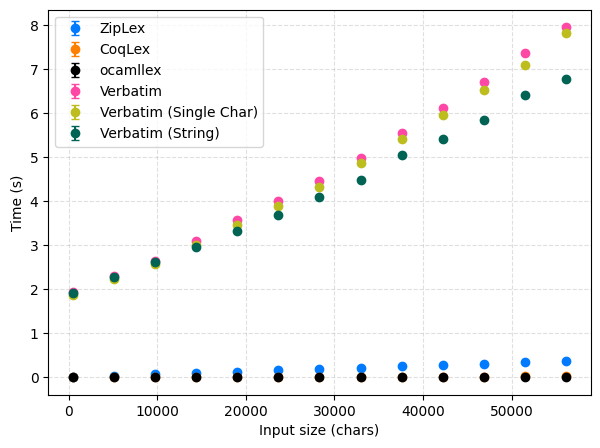

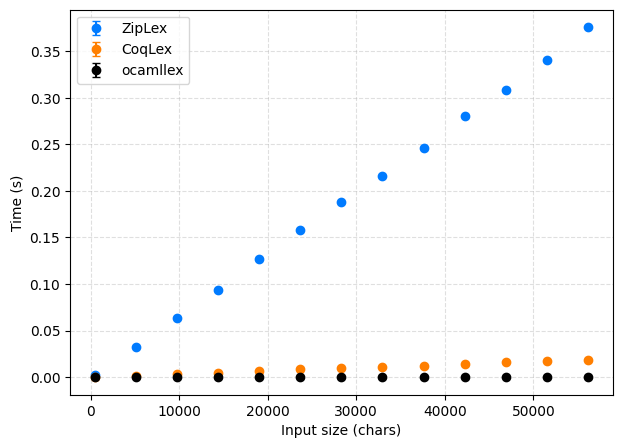

PosixPath('plots/JSON_Lexing_CoqLex_vs_ZipLex_vs_OCamllex.pdf')

In [21]:
plot6(
    ("ZipLex", bench_dict["ZipLex"]),
    ("CoqLex", bench_dict["CoqLex"]),
    ("ocamllex", bench_dict["ocamllex"]),
    ("Verbatim", bench_dict["Verbatim"]),
    ("VerbatimSC", bench_dict["VerbatimSC"]),
    ("VerbatimSt", bench_dict["VerbatimSt"]),
    title="JSON Lexing: CoqLex vs ZipLex vs OCamllex vs Verbatim Variants",
    pretty_data_labels={
        "CoqLex": "CoqLex",
        "Verbatim": "Verbatim",
        "VerbatimSC": "Verbatim (Single Char)",
        "VerbatimSt": "Verbatim (String)",
        "ZipLex": "ZipLex",
        "ocamllex": "ocamllex"
    },
    time_unit="s",
    output_folder="plots",
    fmt="pdf"
)

plot3(
    ("ZipLex", bench_dict["ZipLex"]),
    ("CoqLex", bench_dict["CoqLex"]),
    ("ocamllex", bench_dict["ocamllex"]),
    title="JSON Lexing: CoqLex vs ZipLex vs OCamllex",
    pretty_data_labels={
        "CoqLex": "CoqLex",
        "Verbatim": "Verbatim",
        "VerbatimSC": "Verbatim (Single Char)",
        "VerbatimSt": "Verbatim (String)",
        "ZipLex": "ZipLex",
        "ocamllex": "ocamllex"
    },
    time_unit="s",
    output_folder="plots",
    fmt="pdf"
)